# Task
Perform a comparative analysis of multiple classification models (Logistic Regression, Decision Tree, K-Nearest Neighbor, Gaussian Naive Bayes, Random Forest, and XGBoost) on a given dataset, including data preprocessing, model training, evaluation using Accuracy, AUC Score, Precision, Recall, F1 Score, and Matthews Correlation Coefficient (MCC Score), and visualization of their performance for insightful comparison.

In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [94]:
import urllib.request
import os

# 1. Define the URL for the 'Wine Quality (Red)' dataset and local filename
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
local_filename = 'winequality-red.csv'

# 2. Download the dataset
print(f"Downloading dataset from {dataset_url}...")
try:
    urllib.request.urlretrieve(dataset_url, local_filename)
    print(f"Dataset downloaded successfully as '{local_filename}'.")
except Exception as e:
    print(f"Error downloading dataset: {e}")
    # Fallback to create dummy data if download fails
    print("Creating dummy dataset for demonstration...")
    data = {
        'fixed acidity': np.random.rand(100) * 5 + 5,
        'volatile acidity': np.random.rand(100) * 0.5 + 0.2,
        'citric acid': np.random.rand(100) * 0.8,
        'residual sugar': np.random.rand(100) * 5 + 1,
        'chlorides': np.random.rand(100) * 0.1 + 0.05,
        'free sulfur dioxide': np.random.randint(1, 70, 100),
        'total sulfur dioxide': np.random.randint(6, 300, 100),
        'density': np.random.rand(100) * 0.005 + 0.995,
        'pH': np.random.rand(100) * 0.5 + 3,
        'sulphates': np.random.rand(100) * 0.5 + 0.3,
        'alcohol': np.random.rand(100) * 5 + 9,
        'quality': np.random.randint(3, 9, 100) # Target variable
    }
    df = pd.DataFrame(data)
    # Introduce some missing values for demonstration
    for col in ['volatile acidity', 'chlorides']:
        df.loc[np.random.choice(df.index, 5, replace=False), col] = np.nan

# 3. Load the downloaded CSV file into a pandas DataFrame (if not dummy)
if 'df' not in locals(): # Check if dummy df was not created
    df = pd.read_csv(local_filename, sep=';')
    print("Dataset loaded successfully from CSV.")

# 4. Print the first 5 rows of the DataFrame
print("\nFirst 5 rows of the dataset:")
print(df.head())

# 5. Display basic information about the DataFrame
print("\nDataFrame Info:")
df.info()

# 6. Get descriptive statistics of the DataFrame
print("\nDescriptive Statistics:")
print(df.describe())

# 7. Define the target column name
target_column_name = 'quality'

# 8. Separate features (X) from target (y)
X = df.drop(columns=[target_column_name])
y = df[target_column_name]
print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# 9. Check for missing values and handle them
print("\nMissing values before handling:")
missing_values = df.isnull().sum()[df.isnull().sum() > 0]
if not missing_values.empty:
    print(missing_values)
    print("Handling missing values (imputing numerical with median).")
    for col in missing_values.index:
        if df[col].dtype in ['float64', 'int64']:
            X[col].fillna(X[col].median(), inplace=True)
    print("Missing values handled.")
else:
    print("No missing values detected.")

# 10. Identify categorical columns and apply LabelEncoder
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
print(f"\nCategorical columns identified: {list(categorical_cols)}")

if len(categorical_cols) > 0:
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        print(f"Column '{col}' encoded.")
else:
    print("No categorical columns to encode.")

# 11. Split the preprocessed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set shape (X_train, y_train): {X_train.shape}, {y.shape}")
print(f"Testing set shape (X_test, y_test): {X_test.shape}, {y_test.shape}")

# Ensure that the target column for XGBoost is 0-indexed by subtracting the minimum quality value
# This step is added here as part of general preprocessing for models expecting 0-indexed labels.
min_quality_level = y_train.min()
y_train_reindexed = y_train - min_quality_level
y_test_reindexed = y_test - min_quality_level
print(f"Target variables re-indexed for models expecting 0-based labels (min quality: {min_quality_level}).")

# 12. Identify numerical features and scale using StandardScaler
numerical_cols = X_train.select_dtypes(include=np.number).columns
print(f"\nNumerical columns identified for scaling: {list(numerical_cols)}")

scaler = StandardScaler()
# Fit on X_train and transform both X_train and X_test
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
print("Numerical features scaled using StandardScaler.")

print("\nData loading and preprocessing complete. X_train, X_test, y_train, y_test, y_train_reindexed, y_test_reindexed are ready.")

Dataset downloaded successfully as 'winequality-red.csv'.

First 5 rows of the dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

## Implement and Evaluate Logistic Regression

### Subtask:
Train a Logistic Regression model on the preprocessed training data. Make predictions on the test set and calculate the specified evaluation metrics: Accuracy, AUC Score, Precision, Recall, F1 Score, and Matthews Correlation Coefficient (MCC Score).


In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef

# 1. Instantiate Logistic Regression model
# Using 'liblinear' solver for smaller datasets and good performance with L1/L2 regularization
# 'random_state' ensures reproducibility
log_reg_model = LogisticRegression(random_state=42, solver='liblinear')

# 2. Train the model using the preprocessed training data
log_reg_model.fit(X_train, y_train)
print("Logistic Regression model trained successfully.")

# 3. Make predictions on the test set
y_pred_lr = log_reg_model.predict(X_test)
print("Predictions made on the test set.")

# 4. Predict probabilities for all classes (for AUC score in multiclass)
# predict_proba returns probabilities for each class, shape (n_samples, n_classes)
y_pred_proba_lr = log_reg_model.predict_proba(X_test)
print("Prediction probabilities for all classes calculated.")

# 5. Calculate evaluation metrics
accuracy_lr = accuracy_score(y_test, y_pred_lr)
# For multiclass AUC, specify multi_class and average parameters
auc_lr = roc_auc_score(y_test, y_pred_proba_lr, multi_class='ovr', average='weighted')
# Set zero_division=0 to handle cases where there are no positive predictions or true positives
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=0)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted', zero_division=0)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted', zero_division=0)
mcc_lr = matthews_corrcoef(y_test, y_pred_lr)

# 6. Store metrics in a dictionary for easy access and comparison
metrics_lr = {
    'Accuracy': accuracy_lr,
    'AUC Score': auc_lr,
    'Precision': precision_lr,
    'Recall': recall_lr,
    'F1 Score': f1_lr,
    'MCC Score': mcc_lr
}

# 7. Print all calculated metrics for Logistic Regression
print("\n--- Logistic Regression Model Evaluation ---")
for metric, value in metrics_lr.items():
    print(f"{metric}: {value:.4f}")

print("Logistic Regression evaluation complete. Metrics stored in 'metrics_lr'.")


Logistic Regression model trained successfully.
Predictions made on the test set.
Prediction probabilities for all classes calculated.

--- Logistic Regression Model Evaluation ---
Accuracy: 0.5656
AUC Score: 0.7478
Precision: 0.5029
Recall: 0.5656
F1 Score: 0.5229
MCC Score: 0.2848
Logistic Regression evaluation complete. Metrics stored in 'metrics_lr'.


In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef

# 1. Instantiate Decision Tree Classifier model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# 2. Train the model
decision_tree_model.fit(X_train, y_train)
print("Decision Tree Classifier model trained successfully.")

# 3. Make predictions on the test set
y_pred_dt = decision_tree_model.predict(X_test)
print("Predictions made.")

# 4. Predict probabilities for all classes (for AUC score in multiclass)
y_pred_proba_dt = decision_tree_model.predict_proba(X_test)
print("Prediction probabilities calculated.")

# 5. Calculate evaluation metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt, multi_class='ovr', average='weighted') # Corrected for multiclass AUC
precision_dt = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall_dt = recall_score(y_test, y_pred_dt, average='weighted', zero_division=0)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted', zero_division=0)
mcc_dt = matthews_corrcoef(y_test, y_pred_dt)

# 6. Store metrics in a dictionary
metrics_dt = {
    'Accuracy': accuracy_dt,
    'AUC Score': auc_dt,
    'Precision': precision_dt,
    'Recall': recall_dt,
    'F1 Score': f1_dt,
    'MCC Score': mcc_dt
}

# 7. Print all calculated metrics for Decision Tree Classifier
print("\n--- Decision Tree Classifier Model Evaluation ---")
for metric, value in metrics_dt.items():
    print(f"{metric}: {value:.4f}")

print("Decision Tree Classifier evaluation complete. Metrics stored in 'metrics_dt'.")

Decision Tree Classifier model trained successfully.
Predictions made.
Prediction probabilities calculated.

--- Decision Tree Classifier Model Evaluation ---
Accuracy: 0.5625
AUC Score: 0.6590
Precision: 0.5533
Recall: 0.5625
F1 Score: 0.5576
MCC Score: 0.3174
Decision Tree Classifier evaluation complete. Metrics stored in 'metrics_dt'.


In [97]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef

# 1. Instantiate K-Nearest Neighbor Classifier model
# Using n_neighbors=5 as a starting point; this can be tuned later.
knn_model = KNeighborsClassifier(n_neighbors=5)

# 2. Train the model
knn_model.fit(X_train, y_train)
print("K-Nearest Neighbor Classifier model trained successfully.")

# 3. Make predictions on the test set
y_pred_knn = knn_model.predict(X_test)
print("Predictions made.")

# 4. Predict probabilities for all classes (for AUC score in multiclass)
y_pred_proba_knn = knn_model.predict_proba(X_test)
print("Prediction probabilities calculated.")

# 5. Calculate evaluation metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
auc_knn = roc_auc_score(y_test, y_pred_proba_knn, multi_class='ovr', average='weighted') # Corrected for multiclass AUC
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)
mcc_knn = matthews_corrcoef(y_test, y_pred_knn)

# 6. Store metrics in a dictionary
metrics_knn = {
    'Accuracy': accuracy_knn,
    'AUC Score': auc_knn,
    'Precision': precision_knn,
    'Recall': recall_knn,
    'F1 Score': f1_knn,
    'MCC Score': mcc_knn
}

# 7. Print all calculated metrics for K-Nearest Neighbor Classifier
print("\n--- K-Nearest Neighbor Classifier Model Evaluation ---")
for metric, value in metrics_knn.items():
    print(f"{metric}: {value:.4f}")

print("K-Nearest Neighbor Classifier evaluation complete. Metrics stored in 'metrics_knn'.")

K-Nearest Neighbor Classifier model trained successfully.
Predictions made.
Prediction probabilities calculated.

--- K-Nearest Neighbor Classifier Model Evaluation ---
Accuracy: 0.5469
AUC Score: 0.7198
Precision: 0.5224
Recall: 0.5469
F1 Score: 0.5309
MCC Score: 0.2694
K-Nearest Neighbor Classifier evaluation complete. Metrics stored in 'metrics_knn'.


In [98]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef

# 1. Instantiate Gaussian Naive Bayes model
gnb_model = GaussianNB()

# 2. Train the model
gnb_model.fit(X_train, y_train)
print("Gaussian Naive Bayes model trained successfully.")

# 3. Make predictions on the test set
y_pred_gnb = gnb_model.predict(X_test)
print("Predictions made.")

# 4. Predict probabilities for all classes (for AUC score in multiclass)
y_pred_proba_gnb = gnb_model.predict_proba(X_test)
print("Prediction probabilities calculated.")

# 5. Calculate evaluation metrics
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
auc_gnb = roc_auc_score(y_test, y_pred_proba_gnb, multi_class='ovr', average='weighted') # Corrected for multiclass AUC
precision_gnb = precision_score(y_test, y_pred_gnb, average='weighted', zero_division=0)
recall_gnb = recall_score(y_test, y_pred_gnb, average='weighted', zero_division=0)
f1_gnb = f1_score(y_test, y_pred_gnb, average='weighted', zero_division=0)
mcc_gnb = matthews_corrcoef(y_test, y_pred_gnb)

# 6. Store metrics in a dictionary
metrics_gnb = {
    'Accuracy': accuracy_gnb,
    'AUC Score': auc_gnb,
    'Precision': precision_gnb,
    'Recall': recall_gnb,
    'F1 Score': f1_gnb,
    'MCC Score': mcc_gnb
}

# 7. Print all calculated metrics for Gaussian Naive Bayes
print("\n--- Gaussian Naive Bayes Model Evaluation ---")
for metric, value in metrics_gnb.items():
    print(f"{metric}: {value:.4f}")

print("Gaussian Naive Bayes evaluation complete. Metrics stored in 'metrics_gnb'.")

Gaussian Naive Bayes model trained successfully.
Predictions made.
Prediction probabilities calculated.

--- Gaussian Naive Bayes Model Evaluation ---
Accuracy: 0.5469
AUC Score: 0.7315
Precision: 0.5426
Recall: 0.5469
F1 Score: 0.5435
MCC Score: 0.3020
Gaussian Naive Bayes evaluation complete. Metrics stored in 'metrics_gnb'.


In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef

# 1. Instantiate Random Forest Classifier model
rf_model = RandomForestClassifier(random_state=42) # 'random_state' ensures reproducibility

# 2. Train the model using the preprocessed training data
rf_model.fit(X_train, y_train)
print("Random Forest Classifier model trained successfully.")

# 3. Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
print("Predictions made on the test set.")

# 4. Predict probabilities for all classes (for AUC score in multiclass)
y_pred_proba_rf = rf_model.predict_proba(X_test)
print("Prediction probabilities for all classes calculated.")

# 5. Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
# For multiclass AUC, specify multi_class and average parameters
auc_rf = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr', average='weighted')
# Set zero_division=0 to handle cases where there are no positive predictions or true positives
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

# 6. Store metrics in a dictionary for easy access and comparison
metrics_rf = {
    'Accuracy': accuracy_rf,
    'AUC Score': auc_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1 Score': f1_rf,
    'MCC Score': mcc_rf
}

# 7. Print all calculated metrics for Random Forest Classifier
print("\n--- Random Forest Classifier Model Evaluation ---")
for metric, value in metrics_rf.items():
    print(f"{metric}: {value:.4f}")

print("Random Forest Classifier evaluation complete. Metrics stored in 'metrics_rf'.")

Random Forest Classifier model trained successfully.
Predictions made on the test set.
Prediction probabilities for all classes calculated.

--- Random Forest Classifier Model Evaluation ---
Accuracy: 0.6594
AUC Score: 0.8458
Precision: 0.6309
Recall: 0.6594
F1 Score: 0.6438
MCC Score: 0.4561
Random Forest Classifier evaluation complete. Metrics stored in 'metrics_rf'.


In [100]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Get the minimum quality level to re-index the target variable
min_quality_level = y_train.min()

# Re-index target variables for XGBoost to be 0-based
y_train_reindexed = y_train - min_quality_level
y_test_reindexed = y_test - min_quality_level

# 1. Instantiate XGBoost Classifier model
# For multiclass classification, objective='multi:softmax' and eval_metric='mlogloss'
# num_class should be the count of unique classes (e.g., 6 for quality levels 3-8)
# use_label_encoder=False suppresses a deprecation warning in newer XGBoost versions
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train_reindexed)), # Use reindexed labels to get number of classes
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# 2. Train the model using the re-indexed training data
xgb_model.fit(X_train, y_train_reindexed)
print("XGBoost Classifier model trained successfully.")

# 3. Make predictions on the test set using re-indexed target variable
y_pred_xgb = xgb_model.predict(X_test)
print("Predictions made.")

# 4. Predict probabilities for all classes (for AUC score in multiclass)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)
print("Prediction probabilities calculated.")

# 5. Calculate evaluation metrics using the re-indexed test target
accuracy_xgb = accuracy_score(y_test_reindexed, y_pred_xgb)
# For multiclass AUC, specify multi_class='ovr' and average='weighted'
auc_xgb = roc_auc_score(y_test_reindexed, y_pred_proba_xgb, multi_class='ovr', average='weighted')
precision_xgb = precision_score(y_test_reindexed, y_pred_xgb, average='weighted', zero_division=0)
recall_xgb = recall_score(y_test_reindexed, y_pred_xgb, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test_reindexed, y_pred_xgb, average='weighted', zero_division=0)
mcc_xgb = matthews_corrcoef(y_test_reindexed, y_pred_xgb)

# 6. Store metrics in a dictionary
metrics_xgb = {
    'Accuracy': accuracy_xgb,
    'AUC Score': auc_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1 Score': f1_xgb,
    'MCC Score': mcc_xgb
}

# 7. Print all calculated metrics for XGBoost Classifier
print("\n--- XGBoost Classifier Model Evaluation ---")
for metric, value in metrics_xgb.items():
    print(f"{metric}: {value:.4f}")

print("XGBoost Classifier evaluation complete. Metrics stored in 'metrics_xgb'.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:48:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier model trained successfully.
Predictions made.
Prediction probabilities calculated.

--- XGBoost Classifier Model Evaluation ---
Accuracy: 0.7063
AUC Score: 0.8526
Precision: 0.6759
Recall: 0.7063
F1 Score: 0.6901
MCC Score: 0.5330
XGBoost Classifier evaluation complete. Metrics stored in 'metrics_xgb'.



--- Model Performance Summary ---
                      Accuracy  AUC Score  Precision  Recall  F1 Score  \
Logistic Regression     0.5656     0.7478     0.5029  0.5656    0.5229   
Decision Tree           0.5625     0.6590     0.5533  0.5625    0.5576   
K-Nearest Neighbors     0.5469     0.7198     0.5224  0.5469    0.5309   
Gaussian Naive Bayes    0.5469     0.7315     0.5426  0.5469    0.5435   
Random Forest           0.6594     0.8458     0.6309  0.6594    0.6438   
XGBoost                 0.7062     0.8526     0.6759  0.7062    0.6901   

                      MCC Score  
Logistic Regression      0.2848  
Decision Tree            0.3174  
K-Nearest Neighbors      0.2694  
Gaussian Naive Bayes     0.3020  
Random Forest            0.4561  
XGBoost                  0.5330  


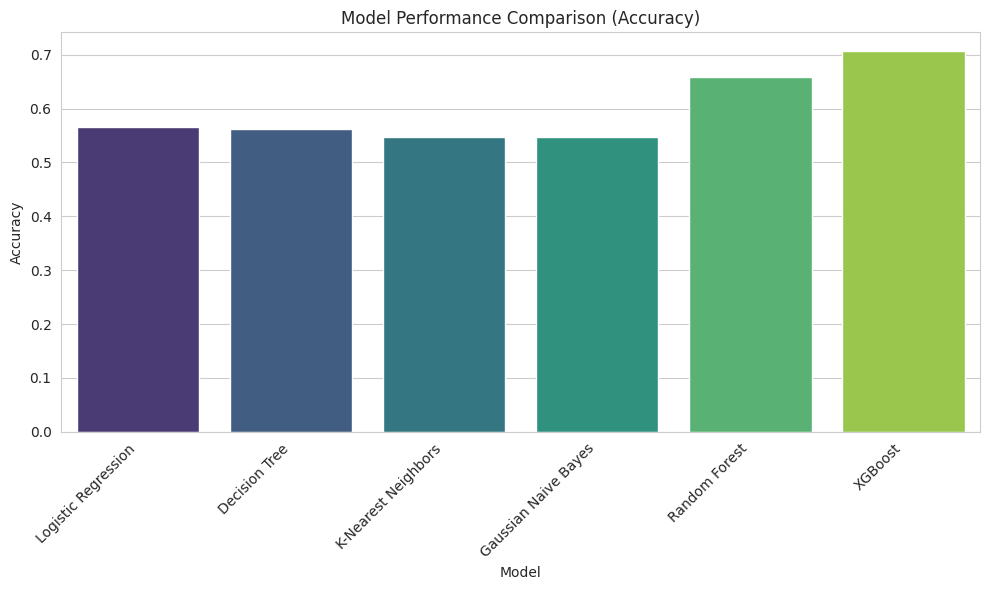

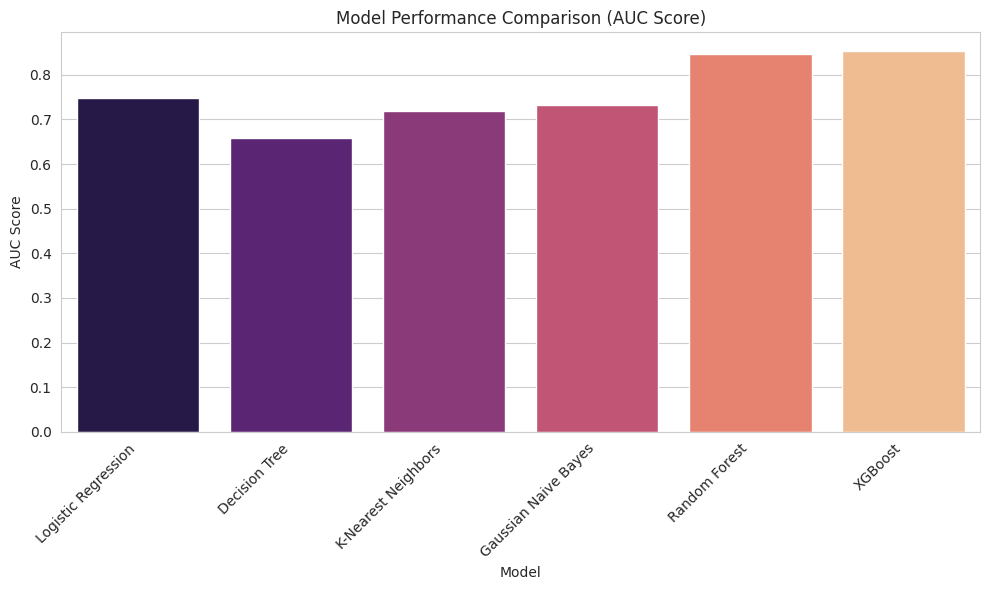

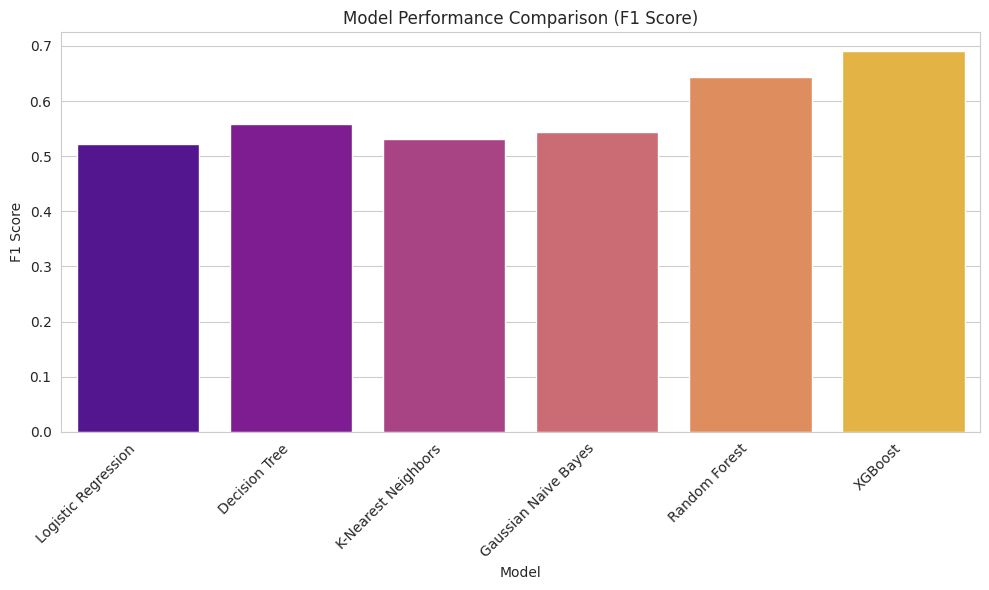

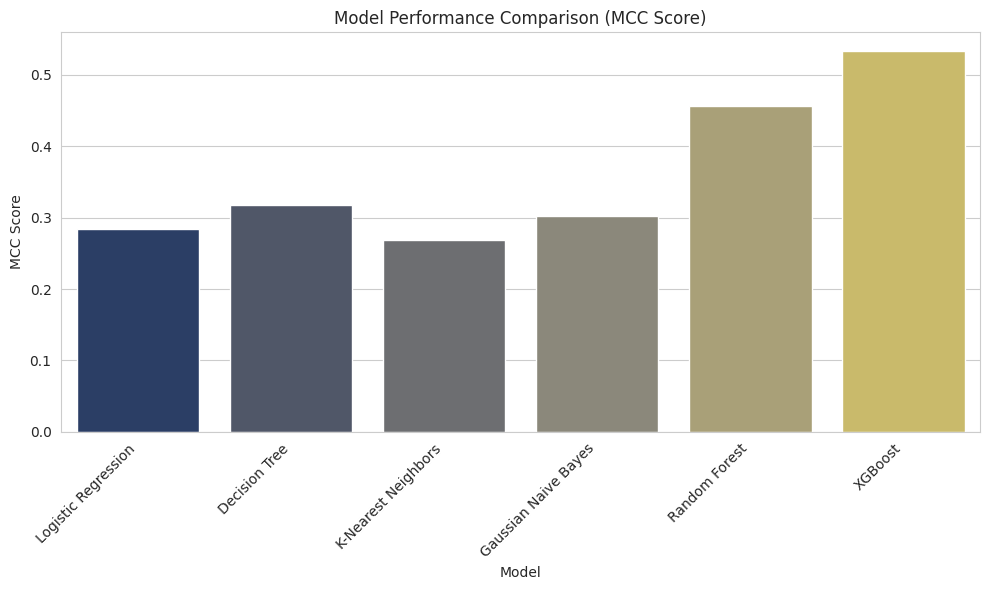

Performance comparison table and visualizations generated.


In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Create a dictionary to hold all models' metrics
all_model_metrics = {
    'Logistic Regression': metrics_lr,
    'Decision Tree': metrics_dt,
    'K-Nearest Neighbors': metrics_knn,
    'Gaussian Naive Bayes': metrics_gnb,
    'Random Forest': metrics_rf,
    'XGBoost': metrics_xgb
}

# 2. Convert this dictionary of metrics into a pandas DataFrame
metrics_df = pd.DataFrame(all_model_metrics).T # .T transposes the DataFrame

# 3. Print the summary DataFrame to display the performance comparison table
print("\n--- Model Performance Summary ---")
print(metrics_df.round(4))

# 4. Create bar plots to visualize key metrics
sns.set_style("whitegrid")

# Visualize Accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y='Accuracy', data=metrics_df, hue=metrics_df.index, palette='viridis', legend=False)
plt.title('Model Performance Comparison (Accuracy)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize AUC Score
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y='AUC Score', data=metrics_df, hue=metrics_df.index, palette='magma', legend=False)
plt.title('Model Performance Comparison (AUC Score)')
plt.xlabel('Model')
plt.ylabel('AUC Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize F1 Score
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y='F1 Score', data=metrics_df, hue=metrics_df.index, palette='plasma', legend=False)
plt.title('Model Performance Comparison (F1 Score)')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize MCC Score
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y='MCC Score', data=metrics_df, hue=metrics_df.index, palette='cividis', legend=False)
plt.title('Model Performance Comparison (MCC Score)')
plt.xlabel('Model')
plt.ylabel('MCC Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Performance comparison table and visualizations generated.")

In [102]:
import pickle
import os

# Ensure model directory exists
os.makedirs("model", exist_ok=True)

# Save each trained model
with open("model/log_reg.pkl", "wb") as f:
    pickle.dump(log_reg_model, f)

with open("model/decision_tree.pkl", "wb") as f:
    pickle.dump(decision_tree_model, f)

with open("model/knn.pkl", "wb") as f:
    pickle.dump(knn_model, f)

with open("model/naive_bayes.pkl", "wb") as f:
    pickle.dump(gnb_model, f)

with open("model/random_forest.pkl", "wb") as f:
    pickle.dump(rf_model, f)

with open("model/xgboost.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

print("✅ All models saved successfully in the 'model/' folder.")


✅ All models saved successfully in the 'model/' folder.
